<a href="https://colab.research.google.com/github/radeonthe1st/USAL_projects/blob/master/Alberto_Botana_Recomendador_de_Videojuegos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Configuración del entorno.

Primeramente se importan los módulos y funciones necesarias para que la sincronización con Google Drive funcione.

In [0]:
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

Se instalan los módulos necesarios no presentes por defecto.

In [0]:
!pip install tqdm
!pip install langdetect
!pip install vaderSentiment
!pip install scikit-surprise

Se importan todos los módulos a utilizar en el programa.

In [0]:
import pandas as pd
import numpy as np
import io
import pickle as pkl
import langdetect
import nltk
import nltk.sentiment as nltks
import matplotlib.pyplot as plt
import surprise
import sklearn.metrics.pairwise
from textblob import TextBlob
from tqdm import tqdm_notebook as tqdm


/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


Se carga la base de datos directamente desde Google Drive. Esto se hace para evitar tener que subir un archivo de 250MB cada vez que se quiera arrancar el entorno, ahorrando así mucho tiempo.

In [0]:
mc_df = pd.read_csv('/content/drive/My Drive/metacritic_game_user_comments.csv')
mc_df.head()

,Unnamed: 0,Title,Platform,Userscore,Comment,Username
0,0,The Legend of Zelda: Ocarina of Time,Nintendo64,10,"Everything in OoT is so near at perfection, it...",SirCaestus
1,1,The Legend of Zelda: Ocarina of Time,Nintendo64,10,I won't bore you with what everyone is already...,Kaistlin
2,2,The Legend of Zelda: Ocarina of Time,Nintendo64,10,Anyone who gives the masterpiece below a 7 or ...,Jacody
3,3,The Legend of Zelda: Ocarina of Time,Nintendo64,10,I'm one of those people who think that this is...,doodlerman
4,4,The Legend of Zelda: Ocarina of Time,Nintendo64,10,This game is the highest rated game on Metacr...,StevenA


# Preprocesado de los datos

Se genera una nueva base de datos conteniendo sólo las entradas cuyas reseñas no estén vacías. A continuación, sobre esa base de datos se retiran las entradas que no estén en inglés. Tras ello, se efectúa un dropNA para eliminar de la base de datos las entradas con valores no válidos.

In [0]:
mc_no_empty_comments=mc_df[mc_df['Comment']!=' ']

In [0]:
# Se quitan los comentarios que no estén en inglés

skip=0

try:
  mc_no_empty_comments = pd.read_pickle('/content/drive/My Drive/mc_english_skip.pkl')
  skip=1
  print('Archivo auxiliar detectado, saltando los cálculos.')
except:
  print('Archivo auxiliar no detectado, procediendo al preprocesado.')

if skip==0:
  idioma_comentario = []
  length=len(mc_no_empty_comments)
  for i in tqdm(range(length),desc='Detectando idioma...'):
    try:
      idioma = langdetect.detect(mc_no_empty_comments['Comment'][i])
      idioma_comentario.append(idioma)
    except:
      idioma = 'desc'
      idioma_comentario.append(idioma)

  #Comprobamos que hay tantos como entradas

  print('Entradas en base de datos: ', len(mc_no_empty_comments))
  print('Entradas detectadas con idioma: ', len(idioma_comentario))

  mc_no_empty_comments['Language']=idioma_comentario

  mc_no_empty_comments.to_pickle('/content/drive/My Drive/mc_english_skip.pkl')
  mc_no_empty_comments.head()

Saved ya a lotta time!


In [0]:
mc_english = mc_no_empty_comments[mc_no_empty_comments['Language']=='en']
mc_other_lang = mc_no_empty_comments[mc_no_empty_comments['Language'] !='en']
mc_english_dirty = mc_english.copy()
mc_english.dropna(inplace=True)
mc_english.to_csv('mc_eng_clean')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Without dropNA:  271413
With dropNA:  271410


Como un extra, se forma una base de datos extra sólo con las reseñas en español, con el fin de estudiar el porcentaje de su presencia.

In [0]:
mc_esp = mc_other_lang[mc_other_lang['Language']=='es']

print('Inglés: ', len(mc_english))
print('Extranjero: ', len(mc_other_lang))
print('En español: ', len(mc_esp))
print('Total: ', len(mc_no_empty_comments))
print('Porcentaje extranjeros: ', len(mc_other_lang)/len(mc_no_empty_comments)*100)
print('Porcentaje español: ',len(mc_esp)/len(mc_no_empty_comments)*100)

283983
12570
4714


Se normalizan las puntuaciones de la base de datos para poder evaluar los analizadores posteriormente.

In [0]:
mc_english.dropna(inplace=True)
norm_scores=[]

for score in mc_english['Userscore']:
  if score <= 3:
    norm_scores.append(-1)
  elif score >=7:
    norm_scores.append(1)
  else:
    norm_scores.append(0)

mc_english['Normalized_Userscore'] = norm_scores

# Análisis de sentimiento

In [0]:
skip=0

try:
  mc_english = pd.read_pickle('/content/drive/My Drive/mc_english_skip2.pkl')
  skip=1
  print('Base de datos de sentimientos analizados encontrada.')
except:
  print('Datos auxiliares no encontrados: Calculando...')


if skip==0:
  mc_english.dropna(inplace=True)
  nltk.download('vader_lexicon')
  v_scores=[]
  tb_scores=[]
  SIA=nltks.vader.SentimentIntensityAnalyzer()
  for i in tqdm(mc_english['Comment'],desc='Analizando sentimientos...'):
    v_score=SIA.polarity_scores(i)['compound']
    v_scores.append(v_score)
    tb_comment = TextBlob(i)
    tb_scores.append(tb_comment.sentiment.polarity)

  vader_scores_df=pd.DataFrame(v_scores)
  textblob_scores_df=pd.DataFrame(tb_scores)

  with open('/content/drive/My Drive/v_scores.pkl','wb') as titlefile:
    pkl.dump(v_scores, titlefile)

  with open('/content/drive/My Drive/tb_scores.pkl','wb') as titlefile:
    pkl.dump(tb_scores, titlefile)

  mc_english['Vader Score']=vader_scores_df
  mc_english['TB Score']=textblob_scores_df

  mc_english.dropna(inplace=True)

  mc_english.to_pickle('/content/drive/My Drive/mc_english_skip2.pkl')
else:
  with open('/content/drive/My Drive/v_scores.pkl', 'rb') as file:
      v_scores = pkl.load(file)
  vader_scores_df=pd.DataFrame(v_scores)

  with open('/content/drive/My Drive/tb_scores.pkl', 'rb') as file:
      tb_scores = pkl.load(file)
  textblob_scores_df=pd.DataFrame(tb_scores)


Saved ya a lotta time!


In [0]:
mc_english_backup = mc_english.copy()

In [0]:
print('Vader_DF: ',len(vader_scores_df))
print('Vader en mc_english: ',len(mc_english['Vader Score']))
print('TB_DF: ',len(textblob_scores_df))
print('TB en mc_english: ', len(mc_english['TB Score']))
print(len(mc_english['Normalized_Userscore']))

Vader_DF:  259311
Vader en mc_english:  247695
TB_DF:  259311
TB en mc_english:  247695
247695


# Estudio de rendimiento de los analizadores

In [0]:
import seaborn as sns
import sklearn.metrics

# Función auxiliar para imprimir matrices de confusión (Obtenido de https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823)

def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=18,colormap="inferno"):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d",cmap=colormap)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Se normalizan las puntiaciones obtenidas de los analizadores de sentimientos.

In [0]:
print('Database: ', len(mc_english))
print('VScores: ', len(v_scores))
print('TBScores: ', len(tb_scores))

#AUX: vader normalization
norm_vader=[]

for score in mc_english['Vader Score']:
  if score <= -0.1:
    norm_vader.append(-1)
  elif score >= 0.1:
    norm_vader.append(1)
  else:
    norm_vader.append(0)

#AUX: TextBlob normalization
norm_tb=[]

for score in mc_english['TB Score']:
  if score <= -0.1:
    norm_tb.append(-1)
  elif score >= 0.1:
    norm_tb.append(1)
  else:
    norm_tb.append(0)

norm_scores2 = np.asarray(norm_scores)
v_scores2 = np.asarray(norm_vader)
tb_scores2 = np.asarray(norm_tb)
vader_conf_mat = sklearn.metrics.confusion_matrix(y_true = mc_english['Normalized_Userscore'], y_pred = norm_vader)
textblob_conf_mat = sklearn.metrics.confusion_matrix(y_true = mc_english['Normalized_Userscore'], y_pred= norm_tb)

Database:  247695
VScores:  259311
TBScores:  259311


Cálculo de las métricas de rendimiento de los analizadores.

In [0]:
vader_tp=vader_conf_mat[2,2]
vader_tn=vader_conf_mat[0,0]+vader_conf_mat[1,0]+vader_conf_mat[0,1]+vader_conf_mat[1,1]
vader_fp=vader_conf_mat[0,2]+vader_conf_mat[1,2]
vader_fn=vader_conf_mat[2,0]+vader_conf_mat[2,1]

vader_recall = vader_tp/(vader_tp+vader_fn)
vader_precision= vader_tp/(vader_tp+vader_fp)
vader_accuracy = (vader_tp+vader_tn)/(vader_tp+vader_tn+vader_fp+vader_fn)
vader_f1 = 2*vader_precision*vader_recall/(vader_precision+vader_recall)

print('Vader Recall: ', vader_recall)
print('Vader Precision: ', vader_precision)
print('Vader Accuracy: ', vader_accuracy)
print('Vader F1: ', vader_f1)

Vader Recall:  0.7824346269488646
Vader Precision:  0.7551675977653631
Vader Accuracy:  0.6450271503260058
Vader F1:  0.7685593427796041


In [0]:
tb_tp=textblob_conf_mat[2,2]
tb_tn=textblob_conf_mat[0,0]+textblob_conf_mat[1,0]+textblob_conf_mat[0,1]+textblob_conf_mat[1,1]
tb_fp=textblob_conf_mat[0,2]+textblob_conf_mat[1,2]
tb_fn=textblob_conf_mat[2,0]+textblob_conf_mat[2,1]

tb_recall = tb_tp/(tb_tp+tb_fn)
tb_precision= tb_tp/(tb_tp+tb_fp)
tb_accuracy = (tb_tp+tb_tn)/(tb_tp+tb_tn+tb_fp+tb_fn)
tb_f1 = 2*tb_precision*tb_recall/(tb_precision+tb_recall)

print('TextBlob Recall: ', tb_recall)
print('TextBlob Precision: ', tb_precision)
print('TextBlob Accuracy: ', tb_accuracy)
print('TextBlob F1: ', tb_f1)

TextBlob Recall:  0.5008923642561219
TextBlob Precision:  0.75458200784795
TextBlob Accuracy:  0.5013181533741092
TextBlob F1:  0.6021060633880626


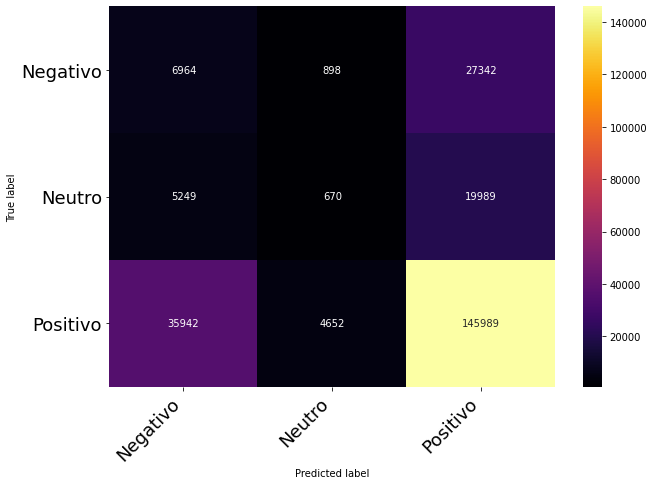

In [0]:
vader_cm = print_confusion_matrix(vader_conf_mat, class_names=['Negativo','Neutro','Positivo'])

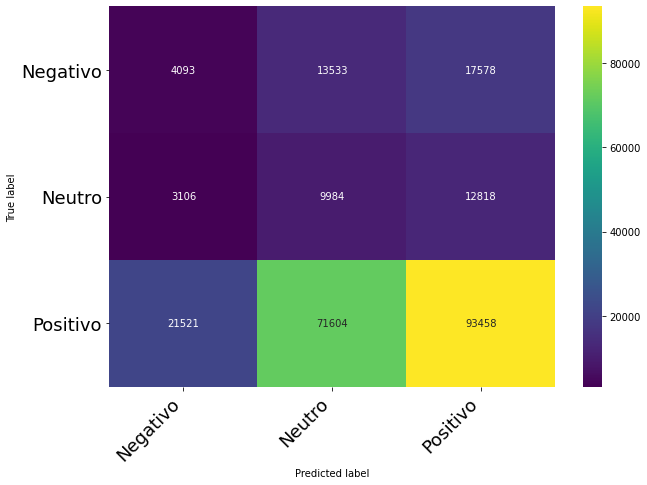

In [0]:
textblob_cm = print_confusion_matrix(textblob_conf_mat, class_names=['Negativo','Neutro','Positivo'],colormap='viridis')

# Construcción del recomendador de videojuegos.

In [0]:
mc_english = mc_english_backup.copy()
mc_english.columns
mc_english.drop(columns=['Unnamed: 0'],inplace=True)

Se crean matrices auxiliares para calcular las matrices de siilitudes.

In [0]:
mc_pivot_avg = pd.pivot_table(mc_english, values = ['Userscore'], index = ['Title', 'Platform', 'Username'], aggfunc = np.mean).unstack()

aux_avg = mc_pivot_avg.mean(axis=0)

mc_pivot_minus_avg = mc_pivot_avg - aux_avg
mc_pivot_minus_avg.fillna(0,inplace=True)

#Ahora con Vader

vader_pivot_avg = pd.pivot_table(mc_english, values=['Vader Score'], index = ['Title', 'Platform', 'Username'], aggfunc = np.mean).unstack()

vader_aux_avg = vader_pivot_avg.mean(axis=0)

vader_pivot_minus_avg = vader_pivot_avg - vader_aux_avg
vader_pivot_minus_avg.fillna(0,inplace=True)

#Y ahora con TextBlob

tb_pivot_avg = pd.pivot_table(mc_english, values=['TB Score'], index = ['Title', 'Platform', 'Username'], aggfunc = np.mean).unstack()

tb_aux_avg = tb_pivot_avg.mean(axis=0)

tb_pivot_minus_avg = tb_pivot_avg - tb_aux_avg
tb_pivot_minus_avg.fillna(0,inplace=True)

Se computan las tres matrices de distancias, intentando cargarlas desde Drive si están disponibles, ya que es un proceso que requiere mucha RAM.

In [0]:
skip=0
try:
  with open('/content/drive/My Drive/cos_dist.pkl', 'rb') as file:
    cos_dists = pkl.load(file)
  print('Matriz de distancias 1 encontrada.')
  skip=1
except:
  pass

if skip==0:
  cos_dists= sklearn.metrics.pairwise.cosine_distances(mc_pivot_minus_avg)
  with open('/content/drive/My Drive/cos_dist.pkl','wb') as titlefile:
    pkl.dump(cos_dists, titlefile)

Te salvé computar matriz 1.


In [0]:
skip=0
try:
  with open('/content/drive/My Drive/vad_cos_dist.pkl', 'rb') as file:
    vad_cos_dists = pkl.load(file)
  print('Matriz de distancias 2 encontrada.')
  skip=1
except:
  pass

if skip==0:
  vad_cos_dists=sklearn.metrics.pairwise.cosine_distances(vader_pivot_minus_avg)
  with open('/content/drive/My Drive/vad_cos_dist.pkl','wb') as titlefile:
    pkl.dump(vad_cos_dists, titlefile)

Te salvé computar matriz 2.


In [0]:
skip=0
try:
  with open('/content/drive/My Drive/tb_cos_dist.pkl', 'rb') as file:
    tb_cos_dists = pkl.load(file)
  print('Matriz de distancias 3 encontrada.')
  skip=1
except:
  pass

if skip==0:
  tb_cos_dists=sklearn.metrics.pairwise.cosine_distances(tb_pivot_minus_avg)
  with open('/content/drive/My Drive/tb_cos_dist.pkl','wb') as titlefile:
    pkl.dump(tb_cos_dists, titlefile)

Te salvé computar matriz 3.


In [0]:
cos_dists_df = pd.DataFrame(cos_dists,columns=mc_pivot_minus_avg.index)
cos_dists_df.index = cos_dists_df.columns

vad_cos_dists_df = pd.DataFrame(vad_cos_dists,columns=vader_pivot_minus_avg.index)
vad_cos_dists_df.index = vad_cos_dists_df.columns

tb_cos_dists_df = pd.DataFrame(tb_cos_dists,columns=tb_pivot_minus_avg.index)
tb_cos_dists_df.index = tb_cos_dists_df.columns

# Hacer funcionar recomendador

Se crean las funciones para conseguir los títulos recomendados en cada analizador.

In [0]:
def get_similar_games_actual(games_list, n=100):
    
    games = [game for game in games_list if game in cos_dists_df.columns]
    games_summed = cos_dists_df[games_list].apply(lambda row: np.sum(row), axis=1)
    games_summed = games_summed.sort_values(ascending=False)
    
    ranked_games = games_summed.index[games_summed.isin(games_list)==False]
    ranked_games = ranked_games.tolist()
    
    for g in games_list:
        ranked_games.remove(g)
    
    if n is None:
        return ranked_games
    else:
        return ranked_games[:n]

In [0]:
def get_similar_games_vader(games_list, n=100):
    
    games = [game for game in games_list if game in vad_cos_dists_df.columns]
    games_summed = vad_cos_dists_df[games_list].apply(lambda row: np.sum(row), axis=1)
    games_summed = games_summed.sort_values(ascending=False)
    
    ranked_games = games_summed.index[games_summed.isin(games_list)==False]
    ranked_games = ranked_games.tolist()
    
    for g in games_list:
        ranked_games.remove(g)
    
    if n is None:
        return ranked_games
    else:
        return ranked_games[:n]

In [0]:
def get_similar_games_tb(games_list, n=100):
    
    games = [game for game in games_list if game in tb_cos_dists_df.columns]
    games_summed = tb_cos_dists_df[games_list].apply(lambda row: np.sum(row), axis=1)
    games_summed = games_summed.sort_values(ascending=False)
    
    ranked_games = games_summed.index[games_summed.isin(games_list)==False]
    ranked_games = ranked_games.tolist()
    
    for g in games_list:
        ranked_games.remove(g)
    
    if n is None:
        return ranked_games
    else:
        return ranked_games[:n]

Finalmente, se da una lista con los títulos de preferencia del usuario y se llama a las tres funciones definidas previamente, proporcionando así los títulos recomendados.

In [0]:
#games_i_like = [("Baldur's Gate II: Shadows of Amn", 'PC'), ("BioShock",'PlayStation3')]
#games_i_like=[("Planescape: Torment","PC"), ("Fallout: New Vegas","PC"),("Dishonored 2","PC")]
#games_i_like = [("The Legend of Zelda: Breath of the Wild", 'Switch')]
games_i_like = [("Super Mario Sunshine","GameCube"),("Super Mario 64","Nintendo64"),("Super Mario Galaxy","Wii")]
games_i_like = [("DOOM","PC"),("Metal Gear Rising: Revengeance","PC")]
games_i_like = [("Need for Speed Most Wanted","PlayStation2"),("Burnout Paradise: The Ultimate Box","PC"), ("Gran Turismo 5","PlayStation3")]

print('--Recomendaciones Base')
for i, game in enumerate(get_similar_games_actual(games_i_like, 5)):
    print("%d. %s on %s" % (i+1, game[0], game[1]))

print('--Recomendaciones Vader')
for i, game in enumerate(get_similar_games_vader(games_i_like, 5)):
    print("%d. %s on %s" % (i+1, game[0], game[1]))

print('--Recomendaciones TextBlob')
for i, game in enumerate(get_similar_games_tb(games_i_like, 5)):
    print("%d. %s on %s" % (i+1, game[0], game[1]))

--Recomendaciones Base
1. Test Drive V-Rally on Dreamcast
2. Midnight Club: Los Angeles on PlayStation3
3. Forza Motorsport 3 on Xbox360
4. Need for Speed Underground on PlayStation2
5. Time Gentlemen, Please! on PC
--Recomendaciones Vader
1. Medal of Honor Underground on PlayStation
2. 80 Days (2015) on PC
3. Midnight Club: Los Angeles on PlayStation3
4. Football Manager 2010 on PC
5. Time Gentlemen, Please! on PC
--Recomendaciones TextBlob
1. Midnight Club 3: DUB Edition Remix on PlayStation2
2. Neverwinter Nights 2 on PC
3. Medal of Honor Underground on PlayStation
4. F1 2002 on PC
5. Devil May Cry 3: Special Edition on PlayStation2


En caso de no encontrar el título que se busca para ponerlo como preferencia, se crea una pequeña búsqueda utilizando expresiones regulares para poder filtrar dentro de la base de datos.

In [0]:
query = mc_english[mc_english_backup.Title.str.match('(Gran Turismo*)')]
query.Title.unique()

array(['Gran Turismo', 'Gran Turismo 3: A-Spec', 'Gran Turismo 2',
       'Gran Turismo 4', 'Gran Turismo 5'], dtype=object)

In [0]:
query

,Title,Platform,Userscore,Comment,Username,Language,Normalized_Userscore,Vader Score,TB Score
19362,Gran Turismo,PlayStation,10,A game you can just keep coming back to. A cl...,RobG.,en,1,0.3573,0.303939
19363,Gran Turismo,PlayStation,10,Simply one of the best racing games of all tim...,NicolasThe17th,en,1,0.9160,0.394444
19364,Gran Turismo,PlayStation,10,The Best Game Ever? Not quite. But a very impo...,whitefox,en,1,-0.5781,0.400000
19365,Gran Turismo,PlayStation,9,"This game is my first game on playstation, i l...",KevinHeryanto,en,1,0.9871,0.273000
19366,Gran Turismo,PlayStation,10,"it was a good game for the ps one, the graphic...",lalorocks,en,1,0.9837,0.435000
...,...,...,...,...,...,...,...,...,...
218879,Gran Turismo 5,PlayStation3,9,One of the best racing games! It has great gra...,TheCastleFinder,en,1,-0.5859,-0.333333
218881,Gran Turismo 5,PlayStation3,9,"This was, and is, by far, the best simulation ...",NZAnimeManga,en,1,-0.4696,-0.133488
218882,Gran Turismo 5,PlayStation3,9,Fantastic driving simulation game. Definitely ...,Ziggy93,en,1,0.8439,0.300000
218884,Gran Turismo 5,PlayStation3,1,"Wonderful graphics, huge variety of cars and m...",dimitrismugen,en,-1,0.7099,0.037605
